# Analyzing AZ traffic stops

This tutorial is built in Python, a powerful programming language with a wide variety of applications. In addition to Python we will need to bring in some additional tools to make our jobs easier. These tools are:

- [Pandas](https://pandas.pydata.org/) - an open-source toolkit widely used for data analysis. 
- [Altair](https://altair-viz.github.io) - a charting library used in conjunction with Pandas to display data visually.

We need to import these tools before we can start working with them. We also want to assign them shorter names so it's easier to refer to the tools later on.

While we are at it, we are going to set an option so Pandas will display all the columns when we ask it to. We also have to enable Altair so it works with the notebook.

In [120]:
import pandas as pd
import altair as alt

pd.set_option('display.max_columns', 29)
alt.renderers.enable('notebook')

## Loading the data

Now that our tools are in place we can load the data. To do so we will use a function built into Pandas. It's easiest to think of functions as tools that conduct a task. These tools can take different arguments - parameters that help them complete their tasks. In this case we will use the `pd.read_csv` tool. It takes at least one parameter - the name of the file we want to open.

Don't forget where our data is located - in this case it is at `./data/az_2015.csv`.

Since we have mostly data that consists of categories rather than numbers we are going to tell Pandas to import everything as if it was just text using the `dtype = object` argument. This has the added benefit of suppressing a warning issued by Pandas because it cannot determine the data types for each column.

In [121]:
az_stops = pd.read_csv('./data/az_2015.csv', dtype = str)

## Getting to know our data

One of the first steps in data analysis is getting a general feel for the data. What does it look like? How many columns are there? Is there any missing data? Let's start answering some of these questions.

### First let's take a quick peek at the top of the dataset

In [122]:
az_stops.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration,road_number,milepost,consent_search,vehicle_type,ethnicity
0,AZ-2015-000001,AZ,2015-01-01,00:01,NaN,Maricopa County,04013,SR101 6.7 NA,NaN,M,NaN,NaN,White,White,Other movin,Moving violation,FALSE,NaN,NaN,FALSE,Citation,FALSE,6143,11-20,SR101,6.7,FALSE,4DHT 2013,W
1,AZ-2015-000002,AZ,2015-01-01,00:01,NaN,NaN,NaN,NA NA MAIN ST/3RD AVE SAFFORD,NaN,M,NaN,NaN,White,White,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,6181,0-10,NaN,NaN,FALSE,12PU 1997,W
2,AZ-2015-000003,AZ,2015-01-01,00:05,NaN,NaN,NaN,SR347 175 NA,NaN,F,NaN,NaN,Black,Black,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,7469,21-30,SR347,175,FALSE,2DSD 2003,B
3,AZ-2015-000004,AZ,2015-01-01,00:07,NaN,Maricopa County,04013,SR101 7 NA,NaN,F,NaN,NaN,Hispanic,Hispanic,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,7014,11-20,SR101,7,FALSE,4DSD 2011,H
4,AZ-2015-000005,AZ,2015-01-01,00:10,NaN,Maricopa County,04013,I10 131 NA,NaN,M,NaN,NaN,Asian / Pacific Islander,Asian,NaN,NaN,FALSE,NaN,NaN,FALSE,Repair Order,FALSE,6280,11-20,I10,131,FALSE,4DSD 2003,A


This gives us a general idea as to what columns we have and what the data looks like. Notice all the `NaN` values. We will talk about those shortly. Keep in mind that this is only the first few rows. We should get a more comprehensive look at the columns and how they are made up:

In [123]:
az_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450519 entries, 0 to 450518
Data columns (total 29 columns):
id                       450519 non-null object
state                    450519 non-null object
stop_date                450519 non-null object
stop_time                450519 non-null object
location_raw             237984 non-null object
county_name              423829 non-null object
county_fips              423829 non-null object
fine_grained_location    450519 non-null object
police_department        0 non-null object
driver_gender            450519 non-null object
driver_age_raw           0 non-null object
driver_age               0 non-null object
driver_race_raw          450519 non-null object
driver_race              450519 non-null object
violation_raw            86391 non-null object
violation                86391 non-null object
search_conducted         450519 non-null object
search_type_raw          2513 non-null object
search_type              2513 non-null objec

Now we have a list showing information about each column, including:

- The column name
- The number of records which has data in each column
- Whether or not there is missing or null data (see below)
- The data type of the column - in this case everything is listed as an `object`, which is how Pandas describes text fields.

Additionally we get information on how many records are in our data - this translates directly to the number of traffic stops we are analyzing. You will notice it matches up to the counts we checked earlier when grabbing the data.

**Note:** Pandas handles missing, null or blank values a bit differently than we want (These are those `NaN` values we saw above). Normally Pandas would automatically exclude null values from any sort of analysis. We don't necessarily want that. It may be important to keep track of how many records do not have actual data in it for a give column. By specifying everything as text when we import the data it allows us to keep null, missing or blank values in the analysis. But don't worry we will talk about how to handle those later.

### Diving a little deeper

Now that we have a general sense of of our data, let's do some preliminary analysis to see what else we can learn.

One of the first things we want to learn is if there are any gaps in our data that we haven't been able to see so far. Let's start by taking a look at traffic stops by month. To do this we will work with the `stop_date` column, but we will need to convert it to the proper data type before we can perform an analysis on it.

In [124]:
az_stops['stop_date'] = pd.to_datetime(az_stops['stop_date'])

Now that our `stop_date` column is in the correct format, we want to get a count of stops by month to ensure we have the entire year. To do this we will use the `groupby` function. 

Since we only want to count stops by month we should try to count a column that has no missing data - in this case it would be the `id` column. We isolate that column by using the `az_stops['id']` syntax.

The `groupby` function takes several different arguments, but only one is required - what you want to group by. In this case we need to group by month off of the `stop_date` column. We will access that using this method: `az_stops.stop_date.dt.month`.

Lastly, since `groupby` is meant to aggregate data using different mathmatical functions (think sum, average, count, etc) we need to specify what kind of math we want to use when aggregating.

In [125]:
stops_by_month = az_stops[['id']].groupby(by = az_stops.stop_date.dt.month).count()

stops_by_month

,id
stop_date,
1,43571
2,38963
3,41911
4,42311
5,44493
6,39542
7,44663
8,42726
9,40919


Immediately you will see that we have an issue. Every month is present except for December. How should we handle this?

### Taking a visual look at our data

It's nice to have the table showing our counts by month, but sometimes we want more detail. We also probably want to look at this visually rather than in a table, so let's build a bar chart to look at traffic stops by day of the year.

But first we need to do another `groupby`, but this time the syntax will be a bit different.

In [126]:
stops_by_day = az_stops[['stop_date','id']].groupby(by = 'stop_date', as_index = False).count()
stops_by_day.head()

,stop_date,id
0,2015-01-01,1038
1,2015-01-02,1153
2,2015-01-03,997
3,2015-01-04,1035
4,2015-01-05,1186


Before we draw the chart, let's change the name of the `id` column into something that makes sense.

In [127]:
stops_by_day.rename(columns = {'id' : 'traffic_stops'}, inplace = True)
stops_by_day.head()

,stop_date,traffic_stops
0,2015-01-01,1038
1,2015-01-02,1153
2,2015-01-03,997
3,2015-01-04,1035
4,2015-01-05,1186


Now we can draw the chart using Altair. Altair requires us to use several different functions tied together to display the chart. The first function is just starting up a chart and telling it what data we want to use. Then we tell it what type of chart we want (a bar chart in this case). Lastly we tell it what axes we want to use on the chart. 

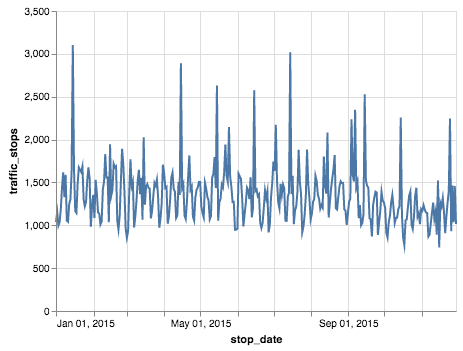

In [128]:
alt.Chart(stops_by_day).mark_line().encode(x = 'stop_date:T', y = 'traffic_stops')

There's something fishy here. You can see there are spikes throughout the year where there are more stops than normal. Let's see if we can find out more information about those spikes. We can do this by filtering the `stops_by_day` data to show only days where more than 2,000 stops occurred.

In [129]:
stops_by_day[stops_by_day['traffic_stops'] >= 2000]

,stop_date,traffic_stops
14,2015-01-15,3104
73,2015-03-15,2028
104,2015-04-15,2890
134,2015-05-15,2632
144,2015-05-25,2145
165,2015-06-15,2576
183,2015-07-03,2174
195,2015-07-15,3018
226,2015-08-15,2082
246,2015-09-04,2236


We really don't have a good answer to what is going on here. Apparently traffic stops tend to spike towards the middle of the month. Sometimes it happens at the beginning of the month and other times before hand. In some cases spikes could be related to holiday enforcement actions such as Fourth of July and Thanksgiving DUI checkpoints. Regardless additional reporting would probably be warranted. However, I don't believe this will impact our analysis greatly because time is not a factor in what we want to uncover.

### Work on your own, part I

Now that we have taken a fairly in-depth look at the `stop_date` column, let's take a closer look at counties where the stops occurred. Use the `county_name` column to generate your own table of traffic stops throughout the state.

In [130]:
# do the group by
stops_by_county = az_stops[['county_name','id']].groupby(by = 'county_name', as_index = False).count()
stops_by_county

,county_name,id
0,Apache County,14152
1,Cochise County,26613
2,Coconino County,33005
3,Gila County,15097
4,Graham County,6489
5,Greenlee County,1053
6,La Paz County,12233
7,Maricopa County,144674
8,Mohave County,20143
9,Navajo County,22506


In [131]:
# change column names
stops_by_county.rename(columns = {'county_name' : 'county', 'id' : 'traffic_stops'}, inplace = True)
stops_by_county

,county,traffic_stops
0,Apache County,14152
1,Cochise County,26613
2,Coconino County,33005
3,Gila County,15097
4,Graham County,6489
5,Greenlee County,1053
6,La Paz County,12233
7,Maricopa County,144674
8,Mohave County,20143
9,Navajo County,22506


### Coming back

So now we have an idea of how many traffic stops occurred in each county. For the purposes of our analysis this actually means very little since we will be taking a look at the entire state. However if you wanted to localize this to your area it is probably a good idea to take a look at how many stops are occurring in your coverage area.

## Visualizing the results

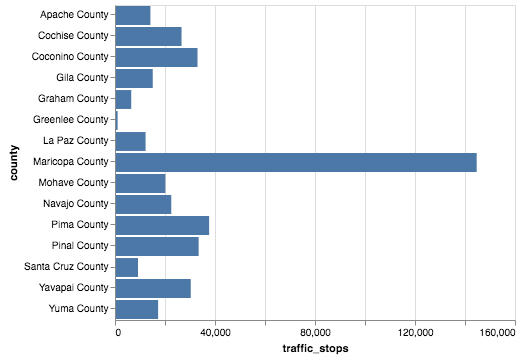

In [132]:
alt.Chart(stops_by_county).mark_bar().encode(x = 'traffic_stops', y = 'county')

## Digging into the demographics

Now we can start playing with demographic data that we have in the data set. Our initial look at the data showed us that there isn't any information on the age of the driver, but we do have pretty good data on gender and race/ethnicity. Rather than examining both gender and race separately, let's see if we can do an analysis on both columns at the same time.

To do this we will use what is called a pivot table. Those of you who have worked with Excel may be familiar with pivot tables. They are a way to restructure your data to provide a different perspective.

Before we get started though, let's do some housekeeping. The `driver_gender` column identifies gender by abbreviation. Let's change that to a full spelling.

In [133]:
az_stops['driver_gender'].replace({'F' : 'Female', 'M' : 'Male'}, inplace = True)
az_stops[['driver_gender']].head()

,driver_gender
0,Male
1,Male
2,Female
3,Female
4,Male


While we are at it let's take a peek at the `driver_race` column.

In [134]:
az_stops[['driver_race']].head()

,driver_race
0,White
1,White
2,Black
3,Hispanic
4,Asian


Much better. Now what we want to know is the number of stops by gender and race. Let's build our pivot table to show us that.

In [135]:
stops_by_sex_race = pd.pivot_table(az_stops, 
                                   columns = 'driver_gender', 
                                   index = 'driver_race', 
                                   values = 'id', 
                                   aggfunc = 'count')
stops_by_sex_race

driver_gender,Female,Male
driver_race,,
Asian,2859,8615
Black,8475,20048
Hispanic,32303,89769
Other,12153,21459
White,83136,171702


Now we have our results. But again, data presented this way is a bit difficult to parse. So we should probably chart this out as well. First we have to clean the table up a bit. We need to get rid of the totals and restructure the dataframe a bit.

In [136]:
stops_by_sex_race = pd.DataFrame(stops_by_sex_race.to_records())

stops_by_sex_race = stops_by_sex_race.melt(id_vars = 'driver_race', var_name = 'driver_gender', value_name = 'traffic_stops')

stops_by_sex_race

,driver_race,driver_gender,traffic_stops
0,Asian,Female,2859
1,Black,Female,8475
2,Hispanic,Female,32303
3,Other,Female,12153
4,White,Female,83136
5,Asian,Male,8615
6,Black,Male,20048
7,Hispanic,Male,89769
8,Other,Male,21459
9,White,Male,171702


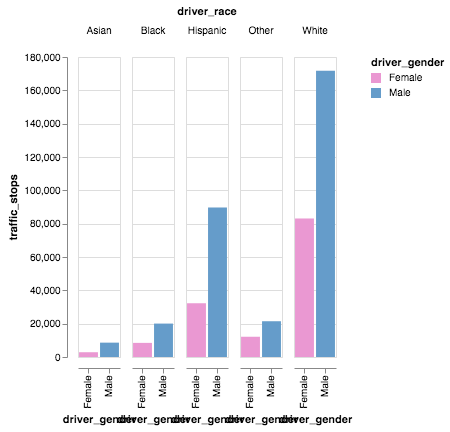

In [137]:

alt.Chart(stops_by_sex_race).mark_bar().encode(
    alt.X('driver_gender:N'),
    alt.Y('traffic_stops:Q'),
    color=alt.Color('driver_gender', scale=alt.Scale(range=["#EA98D2", "#659CCA"])),
    column = 'driver_race'
)

## Do we have a story yet?

At this point it doesn't look like it. As you can see in the graphic above, whites account for a large majority of the stops. But what is wrong with this analysis?

In short it doesn't tell us whether or not minority groups are over or under represented in the data. To find that out we would need to compare stops by race to some other metric. One option would be Census data showing the racial make up of the state's population. Another choice would be to look at demographic breakdowns of licensed drivers. This sort of information is usually requested from the state's Department of Motor Vehicles.

However there is a flaw in this sort of analysis. These are stops conducted by the Arizona Department of Public Safety which means most stops were conducted on highways or state routes. This means drivers stopped by the DPS may not be from this state but rather travelling through from another state – or given the proximity to the border – from Mexico. So population figures from a secondary source would not necessarily represent the population on the road.

Fortunately there is another metric in the data that we can use to measure bias – search patterns.

## Analyzing search patterns

Another metric of bias is whether or not a search was conducted during the course of the traffic stop. For our purposes there are three different types of searches – probable cause, warrant and consent searches. The one we want to focus on are consent searches. This type of search does not require a search warrant and the officer most likely does not have probable cause. As such this search is completely up to the officer's discretion.

There is a `consent_search` column in the data set, but let's explore a bit more before we dive into our analysis.

Let's start by getting a better feel for how many searches were conducted overall, broken out by whether or not they were a consent search.

In [160]:
# talk about null values here
pd.pivot_table(az_stops, index = 'consent_search', 
               columns = 'search_conducted', 
               values = 'id', 
               aggfunc = 'count', 
               margins = True, 
               margins_name = 'total')

search_conducted,FALSE,TRUE,total
consent_search,,,
consent_search,NaN,2513.0,2513
no_search,429094.0,NaN,429094
unknown_search,NaN,18912.0,18912
total,429094.0,21425.0,450519


This is a little difficult to read. What we can tell is that the majority of searches are consent searches. Let's see if we can rename some values to make this easier to search. We can start by getting a count of the null values in the `consent_search` column. These are cases where no searches occurred.

In [139]:
len(az_stops[az_stops['consent_search'].isnull()])

18473

Those null values are cases where a probable cause or warrant search was conducted. Let's replace those null values with a value of `unknown_search`.

In [143]:
az_stops.fillna(value = {'consent_search' : 'unknown_search'}, inplace = True)

Now we need to filter for cases where a search was conducted but it was not a consent search. We will replace those values with `unknown_search` as well.

In [144]:
mask = (az_stops.search_conducted == 'TRUE') & (az_stops.consent_search == 'FALSE')
az_stops.loc[mask, 'consent_search'] = 'unknown_search'

Lastly we will rename `TRUE` values as `consent_search` and any remaining `FALSE` values as `no_search`.

In [145]:
az_stops['consent_search'].replace({'TRUE' : 'consent_search', 'FALSE' : 'no_search'}, inplace = True)

Now build the pivot table again. It should be easier to read and contain more information.

In [146]:
pd.pivot_table(az_stops, index = 'consent_search', 
               columns = 'search_conducted', 
               values = 'id', 
               aggfunc = 'count', 
               margins = True, 
               margins_name = 'total')

search_conducted,FALSE,TRUE,total
consent_search,,,
consent_search,NaN,2513.0,2513
no_search,429094.0,NaN,429094
unknown_search,NaN,18912.0,18912
total,429094.0,21425.0,450519


### Work on your own, part II

Now that we have the `consent_search` column cleaned up, we can start doing our analysis. The first step is to create a pivot table with `consent_search` as the columns, `driver_race` as the race and a count of `id` as the values. Call it `search_rates`. Make sure to convert it back to a dataframe after you are done.

In [148]:
# create the pivot table
search_rates = pd.pivot_table(az_stops, 
                              columns = 'consent_search', 
                              index = 'driver_race', 
                              values = 'id', 
                              aggfunc = 'count', 
                              margins = True, 
                              margins_name = 'total')

search_rates = pd.DataFrame(search_rates.to_records())
search_rates

,driver_race,consent_search,no_search,unknown_search,total
0,Asian,35,11260,179,11474
1,Black,199,26348,1976,28523
2,Hispanic,1563,113518,6991,122072
3,Other,76,31579,1957,33612
4,White,640,246389,7809,254838
5,total,2513,429094,18912,450519


### Coming back

Now we are starting to get somewhere. We now know the number of consent searches, the number of other searches and the total number of stops by race. This is enough for us to start doing some math.

## Calculating search rates

Here we will need to add a new column to our data - a ratio of searches to stops.

In [151]:
# do this without the multiplier first, show how we end up with small numbers 
# and then multiply by 1000 to make it per 1,000 stops
search_rates['search_rate'] = (search_rates['consent_search'] / search_rates['total']) * 1000
search_rates

,driver_race,consent_search,no_search,unknown_search,total,search_rate
0,Asian,35,11260,179,11474,3.050375
1,Black,199,26348,1976,28523,6.976826
2,Hispanic,1563,113518,6991,122072,12.803919
3,Other,76,31579,1957,33612,2.261097
4,White,640,246389,7809,254838,2.511399
5,total,2513,429094,18912,450519,5.578011


## Now we have a story...

A little math was able to do a lot in this case. We can now see that comparatively speaking, Hispanics were searched at rates much higher than whites in 2015. In fact they were searched at a rate nearly twice that of any other racial/ethnic group. So how do we write about that? What is the best way to present those numbers?

### Work on your own, part III

Now that we have some results, let's create a simple bar chart to display them.

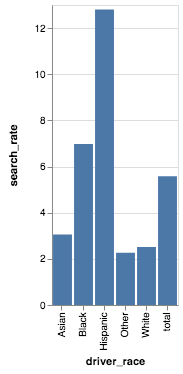

In [153]:
alt.Chart(search_rates).mark_bar().encode(x = 'driver_race', y = 'search_rate')

## But what if...

Some critics may argue that officers have good reason when they search somebody's vehicle and that reason may not be race. Fortunately the data contains a column that can help us check that – `contraband_found`. Basically we can check to see how often a consent_search actually turns up something illegal. 

### Work on your own, part III

This exercise has multiple parts:
1. First you need to filter the `az_stops` dataframe so you are looking at only consent searches. 
2. Then you need to create a pivot table called `hit_rates` based on the `driver_race` and the `contraband_found` columns. Convert it back to a dataframe.
3. Create a new `hit_rate` column and calculate the hit rate per 100 stops.

In [155]:
# filter for consent_searches
consent_searches = az_stops[az_stops.consent_search == 'consent_search']

In [158]:
# create the pivot table
hit_rates = pd.pivot_table(consent_searches, 
                           columns = 'contraband_found', 
                           index = 'driver_race', 
                           values = 'id', 
                           aggfunc = 'count', 
                           margins = True, 
                           margins_name = 'total')

hit_rates = pd.DataFrame(hit_rates.to_records())
# optional rename columns
hit_rates.rename(columns = {'FALSE' : 'miss', 'TRUE' : 'hit'}, inplace = True)
hit_rates

,driver_race,miss,hit,total
0,Asian,30,5,35
1,Black,148,51,199
2,Hispanic,1378,185,1563
3,Other,61,15,76
4,White,479,161,640
5,total,2096,417,2513


In [159]:
# calculate the hit rate
hit_rates['hit_rate'] = (hit_rates['hit'] / hit_rates['total']) * 100

hit_rates

,driver_race,miss,hit,total,hit_rate
0,Asian,30,5,35,14.285714
1,Black,148,51,199,25.628141
2,Hispanic,1378,185,1563,11.836212
3,Other,61,15,76,19.736842
4,White,479,161,640,25.156250
5,total,2096,417,2513,16.593713


### Coming back

Whoa. It looks like we found something amazing here. **Not only are Hispanics searched at rates much higher than any other racial/ethnicity but police find contraband on them at rates lower than any other racial/ethnic group.**

But rather than scrolling up and down the page here, let's combine our results into a single table. To do this we will use the merge function in Pandas. It is very similiar to a SQL join.

In [162]:
combined = search_rates.merge(hit_rates, on = 'driver_race', how = 'inner')
combined

,driver_race,consent_search,no_search,unknown_search,total_x,search_rate,miss,hit,total_y,hit_rate
0,Asian,35,11260,179,11474,3.050375,30,5,35,14.285714
1,Black,199,26348,1976,28523,6.976826,148,51,199,25.628141
2,Hispanic,1563,113518,6991,122072,12.803919,1378,185,1563,11.836212
3,Other,76,31579,1957,33612,2.261097,61,15,76,19.736842
4,White,640,246389,7809,254838,2.511399,479,161,640,25.156250
5,total,2513,429094,18912,450519,5.578011,2096,417,2513,16.593713


And let's clean up the columns a bit. We want to rename the `total_x` to `traffic_stops` and drop the `total_y` column since it duplicates `consent_search`. We can also drop the other search columns as well as the `miss` column. While we are at it, let's re-order the columns.

In [165]:
combined.rename(columns = {'total_x' : 'traffic_stops'}, inplace = True)

combined = combined[['driver_race', 'traffic_stops', 'consent_search', 'hit', 'search_rate', 'hit_rate']].copy()
combined

,driver_race,traffic_stops,consent_search,hit,search_rate,hit_rate
0,Asian,11474,35,5,3.050375,14.285714
1,Black,28523,199,51,6.976826,25.628141
2,Hispanic,122072,1563,185,12.803919,11.836212
3,Other,33612,76,15,2.261097,19.736842
4,White,254838,640,161,2.511399,25.156250
5,total,450519,2513,417,5.578011,16.593713


## Let's visualize it

Again it may help to visualize the data. Let's create a scatter plot comparing hit rates and search rates by race.

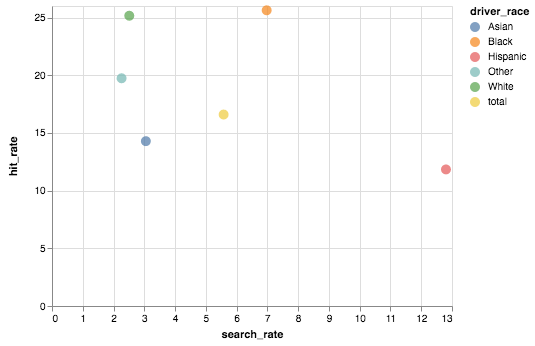

In [175]:
alt.Chart(combined).mark_circle(size = 100).encode(x = 'search_rate', y = 'hit_rate', color = 'driver_race')

## Export your results

In [177]:
combined.to_csv('./results.csv', index = False)